In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import os


In [30]:

latent_dim = 16
lr = 0.1
target_class = 1
steps = 1000
num_samples = 10
noise_scale = 0.1
ae_steps = 30
cl_steps = 30

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        z = self.encoder(x)
        return self.decoder(z)

In [33]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.model(x)

In [34]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

In [35]:
autoencoder = Autoencoder()
classifier = Classifier()

In [36]:
if os.path.exists('autoencoder.pth') and os.path.exists('classifier.pth'):

    autoencoder.load_state_dict(torch.load('autoencoder.pth'))
    classifier.load_state_dict(torch.load('classifier.pth'))
    print("Models loaded from disk!")
else:

    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    for epoch in range(ae_steps):
        for images, _ in train_loader:
            ae_optimizer.zero_grad()
            reconstructions = autoencoder(images)
            loss = nn.MSELoss()(reconstructions, images.view(-1, 784))
            loss.backward()
            ae_optimizer.step()
        print(f"AE Epoch {epoch+1}, Loss: {loss.item():.4f}")


    cls_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    for epoch in range(cl_steps):
        for images, labels in train_loader:
            cls_optimizer.zero_grad()
            outputs = classifier(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            cls_optimizer.step()
        print(f"Classifier Epoch {epoch+1}, Loss: {loss.item():.4f}")

    torch.save(autoencoder.state_dict(), 'autoencoder.pth')
    torch.save(classifier.state_dict(), 'classifier.pth')
    print("Models saved to disk!")


for model in [autoencoder, classifier]:
    for param in model.parameters():
        param.requires_grad = False


def generate_digit(target_class, noise_scale=0.1):

    z = torch.randn(1, latent_dim) + noise_scale * torch.randn(1, latent_dim)
    z.requires_grad_(True)

    optimizer = optim.Adam([z], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()


        generated = autoencoder.decoder(z)
        logits = classifier(generated)
        loss = nn.CrossEntropyLoss()(logits, torch.tensor([target_class]))
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        generated_img = autoencoder.decoder(z).view(28, 28).numpy()

    return generated_img

Models loaded from disk!


In [37]:
generated_images = []
for i in range(num_samples):
    print(f"Generating sample {i+1}/{num_samples}...")
    img = generate_digit(target_class, noise_scale=noise_scale)
    generated_images.append(img)

Generating sample 1/10...
Generating sample 2/10...
Generating sample 3/10...
Generating sample 4/10...
Generating sample 5/10...
Generating sample 6/10...
Generating sample 7/10...
Generating sample 8/10...
Generating sample 9/10...
Generating sample 10/10...


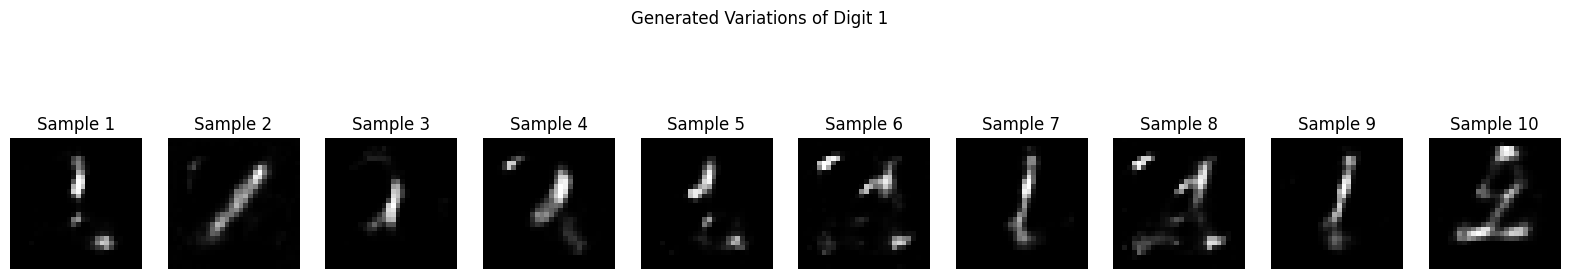

In [38]:
plt.figure(figsize=(20, 4))
for i, img in enumerate(generated_images):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.suptitle(f"Generated Variations of Digit {target_class}")
plt.show()